In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



file = "train_ZoGVYWq.csv"
data = pd.read_csv(file)

def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['renewal'] = data['renewal'].astype('bool')
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data_pre_prepped = pre_prep(data)

In [853]:
data_pre_prepped.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,channel,residence,premium,renewal
id,,,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,True
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,True
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,False
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,True
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,True


## Create dummy vars, then split

In [854]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(data_pre_prepped.drop('renewal', axis=1), data_pre_prepped['renewal'], test_size=0.20, random_state=42)

# train_test_split(data_pre_prepped, data_pre_prepped['renewal'], test_size=0.20, random_state=42)
len(data_with_dummies)

79853

In [855]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 11 columns):
cash_credit    63882 non-null float64
age_in_days    63882 non-null int64
Income         63882 non-null int64
late3          63801 non-null float64
late6          63801 non-null float64
late12         63801 non-null float64
score          61534 non-null float64
prems_paid     63882 non-null int64
channel        63882 non-null category
residence      63882 non-null category
premium        63882 non-null int64
dtypes: category(2), float64(5), int64(4)
memory usage: 5.0+ MB


 # Imputation
 

In [856]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train[['score', 'late3', 'late6', 'late12']] = imp.fit_transform(X_train[['score', 'late3', 'late6', 'late12']])

In [857]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63882 entries, 56158 to 99690
Data columns (total 11 columns):
cash_credit    63882 non-null float64
age_in_days    63882 non-null int64
Income         63882 non-null int64
late3          63882 non-null float64
late6          63882 non-null float64
late12         63882 non-null float64
score          63882 non-null float64
prems_paid     63882 non-null int64
channel        63882 non-null category
residence      63882 non-null category
premium        63882 non-null int64
dtypes: category(2), float64(5), int64(4)
memory usage: 5.0+ MB


In [858]:
X_train.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,channel,residence,premium
id,,,,,,,,,,,
56158,0.527,14248,242270,0.0,0.0,0.0,99.31,8,E,Rural,1200
83192,0.901,18265,203390,0.0,0.0,0.0,99.25,8,B,Urban,9600
22201,0.262,28844,92140,0.0,0.0,0.0,99.11,10,A,Urban,5400
104286,0.868,22642,137620,1.0,0.0,0.0,98.85,17,D,Urban,11700
43583,0.186,18625,249030,0.0,0.0,0.0,99.45,8,A,Rural,20100


## Categorical transformation

In [859]:
def create_dummies(df):
    df_new = pd.get_dummies(data=df.copy(), prefix='channel', columns=['channel'], drop_first=True)
    df_new = pd.get_dummies(data=df_new, prefix='residence', columns=['residence'], drop_first=True)
    return df_new


X_train = create_dummies(X_train)

# Transform features numerically

In [860]:
from sklearn.preprocessing import Binarizer

In [861]:
#biner = Binarizer(threshold=.7)
#X_train[['cash_credit']] = biner.fit_transform(X_train[['cash_credit']])

In [862]:
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, StandardScaler

scaler = StandardScaler()
X_train[['age_in_days']] = scaler.fit_transform(X_train[['age_in_days']])

log_trans = FunctionTransformer(np.log1p)
X_train[['Income']] = log_trans.transform(X_train[['Income']])
# X_train[['late3']] = log_trans.transform(X_train[['late3']])
# X_train[['late6']] = log_trans.transform(X_train[['late6']])
# X_train[['late12']] = log_trans.transform(X_train[['late12']])

prem_trans = FunctionTransformer(lambda x : np.power(x, 1))
X_train[['premium']] = prem_trans.transform(X_train[['premium']])
scaler_prems = StandardScaler()
X_train[['premium']] = scaler_prems.fit_transform(X_train[['premium']])

# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# X_train[['premium']] = qt.fit_transform(X_train[['premium']])

exp_trans = FunctionTransformer(lambda x: np.exp(x/100))
X_train[['score']] = exp_trans.transform(X_train[['score']])

In [863]:
X_train.to_csv("train_imputed_encoded.csv")
X_train.describe()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
count,63882.000000,6.388200e+04,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000,6.388200e+04,63882.000000,63882.000000,63882.000000,63882.000000,63882.000000
mean,0.313499,-2.122218e-16,12.002447,0.245357,0.077804,0.059184,2.693148,10.851946,-8.764717e-17,0.206020,0.150481,0.094048,0.007295,0.605491
std,0.334326,1.000008e+00,0.661145,0.685053,0.433123,0.309787,0.019369,5.155890,1.000008e+00,0.404449,0.357545,0.291898,0.085098,0.488749
min,0.000000,-2.146756e+00,10.087100,0.000000,0.000000,0.000000,2.508287,2.000000,-1.035460e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034000,-7.432534e-01,11.590104,0.000000,0.000000,0.000000,2.686932,7.000000,-5.878761e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.166000,-4.169416e-02,12.021434,0.000000,0.000000,0.000000,2.696353,10.000000,-3.640842e-01,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.536000,7.290410e-01,12.435560,0.000000,0.000000,0.000000,2.705265,14.000000,3.072913e-01,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.604838e+00,18.318234,13.000000,17.000000,11.000000,2.715293,60.000000,5.230712e+00,1.000000,1.000000,1.000000,1.000000,1.000000


# Transform numerics distributions (not for now)

# Train LogReg Model

In [864]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [865]:
m = LogisticRegression()

In [866]:
m.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [867]:
m.coef_[0]

array([-1.86644938e+00,  2.06482257e-01,  2.92648209e-01, -4.29882208e-01,
       -6.76706325e-01, -6.25488894e-01,  9.03472155e-01, -3.95374212e-02,
       -3.57382326e-02, -5.73445392e-02, -1.37339132e-01, -2.25984652e-01,
       -2.79704153e-01,  1.10406244e-03])

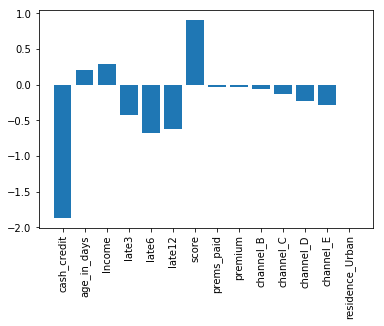

In [868]:
coeffs = dict(zip(X_train.columns, m.coef_[0]))
from pprint import pprint
# pprint(coeffs)
plt.bar(range(len(coeffs)), list(coeffs.values()), align='center')
plt.xticks(range(len(coeffs)), list(coeffs.keys()), rotation=90)

plt.show()

In [869]:
X_train.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
56158,0.527,-0.882758,12.397812,0.0,0.0,0.0,2.699590,8,-1.035460,0,0,0,1,0
83192,0.901,-0.110870,12.222886,0.0,0.0,0.0,2.697971,8,-0.140292,1,0,0,0,1
22201,0.262,1.921942,11.431075,0.0,0.0,0.0,2.694196,10,-0.587876,0,0,0,0,1
104286,0.868,0.730194,11.832259,1.0,0.0,0.0,2.687201,17,0.083499,0,0,1,0,1
43583,0.186,-0.041694,12.425333,0.0,0.0,0.0,2.703372,8,0.978667,0,0,0,0,0


## Prep model test input

In [870]:
X_test = create_dummies(X_test)

sum(X_test.isnull().any(axis=1))

628

In [871]:
def trans(X_test):
    X_test_trans = X_test.copy()
    X_test_trans[['score', 'late3', 'late6', 'late12']] = imp.transform(X_test_trans[['score', 'late3', 'late6', 'late12']])
    #X_test_trans[['cash_credit']] = biner.transform(X_test_trans[['cash_credit']])
    X_test_trans[['Income']] = log_trans.transform(X_test_trans[['Income']])
    # X_test_trans[['late3']] = log_trans.transform(X_test_trans[['late3']])
    # X_test_trans[['late6']] = log_trans.transform(X_test_trans[['late6']])
    # X_test_trans[['late12']] = log_trans.transform(X_test_trans[['late12']])
    X_test_trans[['score']] = exp_trans.transform(X_test_trans[['score']])
    X_test_trans[['premium']] = prem_trans.transform(X_test_trans[['premium']])
    X_test_trans[['premium']] = scaler_prems.fit_transform(X_test_trans[['premium']])

    X_test_trans[['age_in_days']] = scaler.transform(X_test_trans[['age_in_days']])
    return X_test_trans

X_test_trans = trans(X_test)

assert sum(X_test_trans.isnull().any(axis=1))==0

In [872]:
y_proba = m.predict_proba(X_test_trans)[:,1]

## Analysis

In [873]:
print(classification_report(y_true=y_test, y_pred=y_proba>.9))

             precision    recall  f1-score   support

      False       0.26      0.61      0.36      1032
       True       0.97      0.88      0.92     14939

avg / total       0.92      0.86      0.89     15971



In [874]:
#plt.hist(y_proba, bins='auto')

In [875]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=True)
roc_auc = metrics.roc_auc_score(y_test, y_proba)

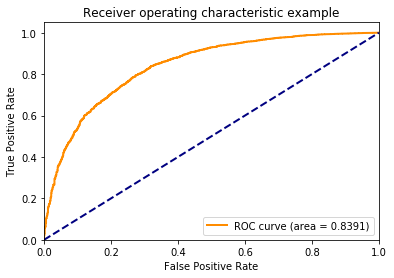

In [876]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Using on test data

In [888]:
data_test = pd.read_csv("test_66516Ee.csv")

def pre_prep(df):
    data = df.copy()
    data.set_index('id', inplace=True)
    data['sourcing_channel'] = data['sourcing_channel'].astype('category') 
    data['residence_area_type'] = data['residence_area_type'].astype('category')
    new_names = {'perc_premium_paid_by_cash_credit': 'cash_credit',
                'Count_3-6_months_late': 'late3',
                'Count_6-12_months_late': 'late6',
                'Count_more_than_12_months_late': 'late12',
                'application_underwriting_score': 'score',
                'residence_area_type': 'residence',
                'no_of_premiums_paid': 'prems_paid',
                'sourcing_channel': 'channel'}
    data.rename(index=str, columns=new_names, inplace=True)
    return data

data_pre_prepped_test = pre_prep(data_test)

In [889]:
test = create_dummies(data_pre_prepped_test)
test = trans(test)

In [890]:
test.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
649,0.001,1.641395,10.842537,0.0,0.0,0.0,2.715293,7,-0.813427,0,0,0,0,0
81136,0.124,0.940220,12.560739,0.0,0.0,0.0,2.689351,19,0.093413,0,0,0,0,1
70762,1.000,-0.321280,12.133669,0.0,0.0,0.0,2.693077,2,0.093413,1,0,0,0,1
53935,0.198,-0.533035,11.724328,0.0,0.0,0.0,2.691234,11,-0.586717,1,0,0,0,0
15476,0.041,-1.585470,12.206178,1.0,0.0,0.0,2.695813,14,-0.133297,0,0,0,0,0


In [891]:
X_test_trans.head()

,cash_credit,age_in_days,Income,late3,late6,late12,score,prems_paid,premium,channel_B,channel_C,channel_D,channel_E,residence_Urban
id,,,,,,,,,,,,,,
67251,0.125,-0.392954,12.104101,0.0,0.0,0.0,2.687469,15,0.300157,0,0,1,0,1
86418,0.021,0.871044,12.032380,0.0,0.0,0.0,2.696353,20,-0.364906,1,0,0,0,1
101134,0.033,0.589152,11.538116,0.0,0.0,0.0,2.674600,7,-0.364906,0,0,0,0,1
55058,0.147,-1.024569,12.507809,0.0,0.0,0.0,2.698780,7,1.408593,0,1,0,0,1
2632,1.000,-1.513604,10.842146,0.0,0.0,0.0,2.712579,3,-0.808280,0,0,0,0,1


In [892]:
y_proba = m.predict_proba(test)[:,1]

In [893]:

out = pd.DataFrame({'id': data_pre_prepped_test.index, 'renewal': y_proba, 'incentives': 200 * np.ones(len(y_proba))})
out.head()

,id,renewal,incentives
0,649,0.986124,200.0
1,81136,0.979425,200.0
2,70762,0.921332,200.0
3,53935,0.969518,200.0
4,15476,0.959812,200.0


In [897]:
out.to_csv('pred.csv', index=False)

In [896]:
out.to_csv?